# Model Validation (Cluster-Based)

1. Merge test features with submission predictions (yhat).
2. Apply feature engineering + preprocessing (fit on train only)
3. Cluster on features only (train + test together)
4. For each test point sharing a cluster with ≥1 train point,
check whether its prediction (yhat) is within tolerance
of at least one train outcome in that cluster

In [41]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

current_directory = Path.cwd()
if current_directory.name == "notebooks":
    project_root = current_directory.parent
elif (current_directory / "src").exists():
    project_root = current_directory
else:
    project_root = current_directory.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.pipeline import build_preprocessor, feature_engineering_transformer

## 1. Load Data

In [42]:
df_train = pd.read_csv("../data/CW1_train.csv")
df_test = pd.read_csv("../data/CW1_test.csv")
df_submission = pd.read_csv("../data/CW1_submission_K23169225.csv")

# Merge test features with submission predictions (yhat)
df_test_with_predictions = pd.concat([df_test, df_submission], axis=1)
df_test_with_predictions.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,...,a7,a8,a9,a10,b6,b7,b8,b9,b10,yhat
0,0.39,Ideal,I,VVS2,60.8,56.0,849,4.74,4.76,2.89,...,0.779133,0.146287,-0.658241,-1.899234,-0.973046,-0.145955,-0.597933,0.915728,0.498678,4.163258
1,1.02,Premium,H,VS1,62.1,59.0,5569,6.43,6.38,3.98,...,-0.698167,0.499753,0.524907,-0.672549,-0.505678,-2.761345,-2.434193,-1.303742,-1.239320,-7.503744
2,0.74,Ideal,G,SI1,61.6,55.0,2760,5.80,5.85,3.59,...,1.057552,1.111710,2.888994,1.489588,0.456911,-0.010021,-1.211698,0.781882,-0.327432,5.193330
3,0.50,Ideal,G,VVS2,62.3,56.0,1935,5.09,5.05,3.16,...,-0.663203,-0.500939,-1.383690,-1.828773,-1.344145,-1.411683,-1.866323,-2.157749,0.341636,-17.310010
4,1.04,Good,E,SI1,63.8,58.0,5766,6.46,6.39,4.10,...,-0.187732,0.239685,0.790332,0.619964,-0.182362,1.342525,1.032296,1.402299,1.165052,-14.827162


## 2. Preprocessing Features
- Fit preprocessor on train only
- Apply same tranformation to test

In [43]:
X_train_raw = df_train.drop(columns=["outcome"])
y_train = df_train["outcome"].values

# Feature engineering
X_train_engineered = feature_engineering_transformer.transform(X_train_raw)

# Preprocessing
preprocessor = build_preprocessor()
preprocessor.fit(X_train_engineered)

X_train = preprocessor.transform(X_train_engineered)

# Use same feature columns as train
X_test_raw = df_test_with_predictions[X_train_raw.columns].copy()
yhat = df_test_with_predictions["yhat"].values

X_test_engineered = feature_engineering_transformer.transform(X_test_raw)
X_test = preprocessor.transform(X_test_engineered)

## 3. Cluster on Features Only

In [44]:
X_combined = np.vstack([X_train, X_test])

n_train, n_test = len(X_train), len(X_test)

kmeans = KMeans(n_clusters=40, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_combined)

cluster_train = cluster_labels[:n_train]
cluster_test = cluster_labels[n_train:]

## 4. Cluster-Based Validation
For each test sample:
- If cluster contains ≥1 train sample: Check if prediction is within tolerance of any train outcome.

In [45]:
tolerance = 0.5 * np.std(y_train)

min_distances = []
validation_mask = []

for index in range(n_test):
    cluster_id = cluster_test[index]
    train_outcomes = y_train[cluster_train == cluster_id]

    if len(train_outcomes) == 0:
        continue

    distance = np.min(np.abs(train_outcomes - yhat[index]))
    min_distances.append(distance)
    validation_mask.append(distance <= tolerance)

min_distances = np.array(min_distances)
validation_mask = np.array(validation_mask)

n_valid = len(validation_mask)
n_passed = np.sum(validation_mask)
n_excluded = n_test - n_valid

print(f"Tolerance: {tolerance:.4f}")
print(f"Test rows with ≥1 train in cluster: {n_valid}")
print(f"Test rows excluded (no train in cluster): {n_excluded}")
if n_valid > 0:
    print(f"Pass rate: {n_passed} / {n_valid} ({100 * n_passed / n_valid:.1f}%)")
else:
    print("Pass rate: N/A (no test rows shared a cluster with train)")

Tolerance: 6.3608
Test rows with ≥1 train in cluster: 1000
Test rows excluded (no train in cluster): 0
Pass rate: 1000 / 1000 (100.0%)


## 5. Error Distribution

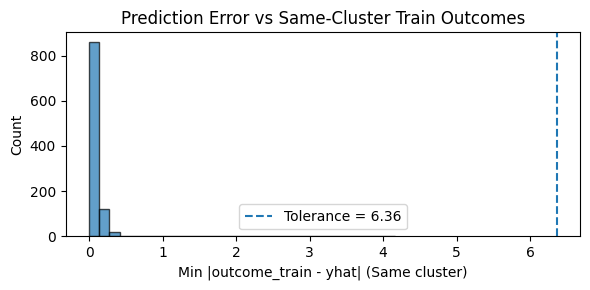

In [46]:
if len(min_distances) > 0:
    plt.figure(figsize=(6, 3))
    plt.hist(min_distances, bins=30, edgecolor="black", alpha=0.7)
    plt.axvline(tolerance, linestyle="--", label=f"Tolerance = {tolerance:.2f}")
    plt.xlabel("Min |outcome_train - yhat| (Same cluster)")
    plt.ylabel("Count")
    plt.title("Prediction Error vs Same-Cluster Train Outcomes")
    plt.legend()
    plt.tight_layout()
    plt.show()